# Forest Fire Prediction

## Import Library

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

%matplotlib inline

## Analisis Data

### Load Data

In [6]:
data = pd.read_csv('/content/forestfires.csv')
data.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


### Get Data Info

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: 'jan' to 'dec'
4. day - day of the week: 'mon' to 'sun'
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3
7. DC - DC index from the FWI system: 7.9 to 860.6
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40
12. rain - outside rain in mm/m2 : 0.0 to 6.4
13. area - the burned area of the forest (in ha): 0.00 to 1090.84
(this output variable is very skewed towards 0.0, thus it may make
sense to model with the logarithm transform).



In [8]:
data.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


### Data Preprocessing

One Hot Encoding

In [9]:
for i in ['month', 'day']:
  enc_dummies = pd.get_dummies(data[i])
  data = pd.concat([data, enc_dummies], axis = 1)
data.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,apr,aug,dec,feb,jan,jul,jun,mar,may,nov,oct,sep,fri,mon,sat,sun,thu,tue,wed
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0


In [10]:
data = data.drop(columns = ['month', 'day'])
data.head()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,apr,aug,dec,feb,jan,jul,jun,mar,may,nov,oct,sep,fri,mon,sat,sun,thu,tue,wed
0,7,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
1,7,4,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
2,7,4,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
3,8,6,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
4,8,6,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0


Logarithm Transform

In [11]:
log_value = []
for x in data['area'].tolist():
  y = np.log(x + 1)
  log_value.append(y)

In [12]:
area_dict = {'area': log_value}
new_data = pd.DataFrame.from_dict(area_dict)
data['area'] = new_data
data.head()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,apr,aug,dec,feb,jan,jul,jun,mar,may,nov,oct,sep,fri,mon,sat,sun,thu,tue,wed
0,7,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
1,7,4,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
2,7,4,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
3,8,6,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
4,8,6,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0


Normalisasi Data

In [13]:
scaler = preprocessing.MinMaxScaler()

In [14]:
names = ['X', 'Y','FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain', 'area']

In [15]:
for i in names:
  data[i] = scaler.fit_transform(data[[i]].to_numpy().reshape(-1, 1))
data.head()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,apr,aug,dec,feb,jan,jul,jun,mar,may,nov,oct,sep,fri,mon,sat,sun,thu,tue,wed
0,0.750,0.428571,0.870968,0.086492,0.101325,0.090909,0.192926,0.423529,0.700000,0.00000,0.0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
1,0.750,0.285714,0.927742,0.118194,0.775419,0.119430,0.508039,0.211765,0.055556,0.00000,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
2,0.750,0.285714,0.927742,0.146795,0.796294,0.119430,0.398714,0.211765,0.100000,0.00000,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
3,0.875,0.571429,0.941935,0.110958,0.081623,0.160428,0.196141,0.964706,0.400000,0.03125,0.0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
4,0.875,0.571429,0.910968,0.172984,0.110590,0.171123,0.295820,0.988235,0.155556,0.00000,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0


## Visualisasi Data

In [16]:
data2 = data[['X','Y','FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain', 'area']]
data3 = data[['X','Y','FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']]

### Pair Plot

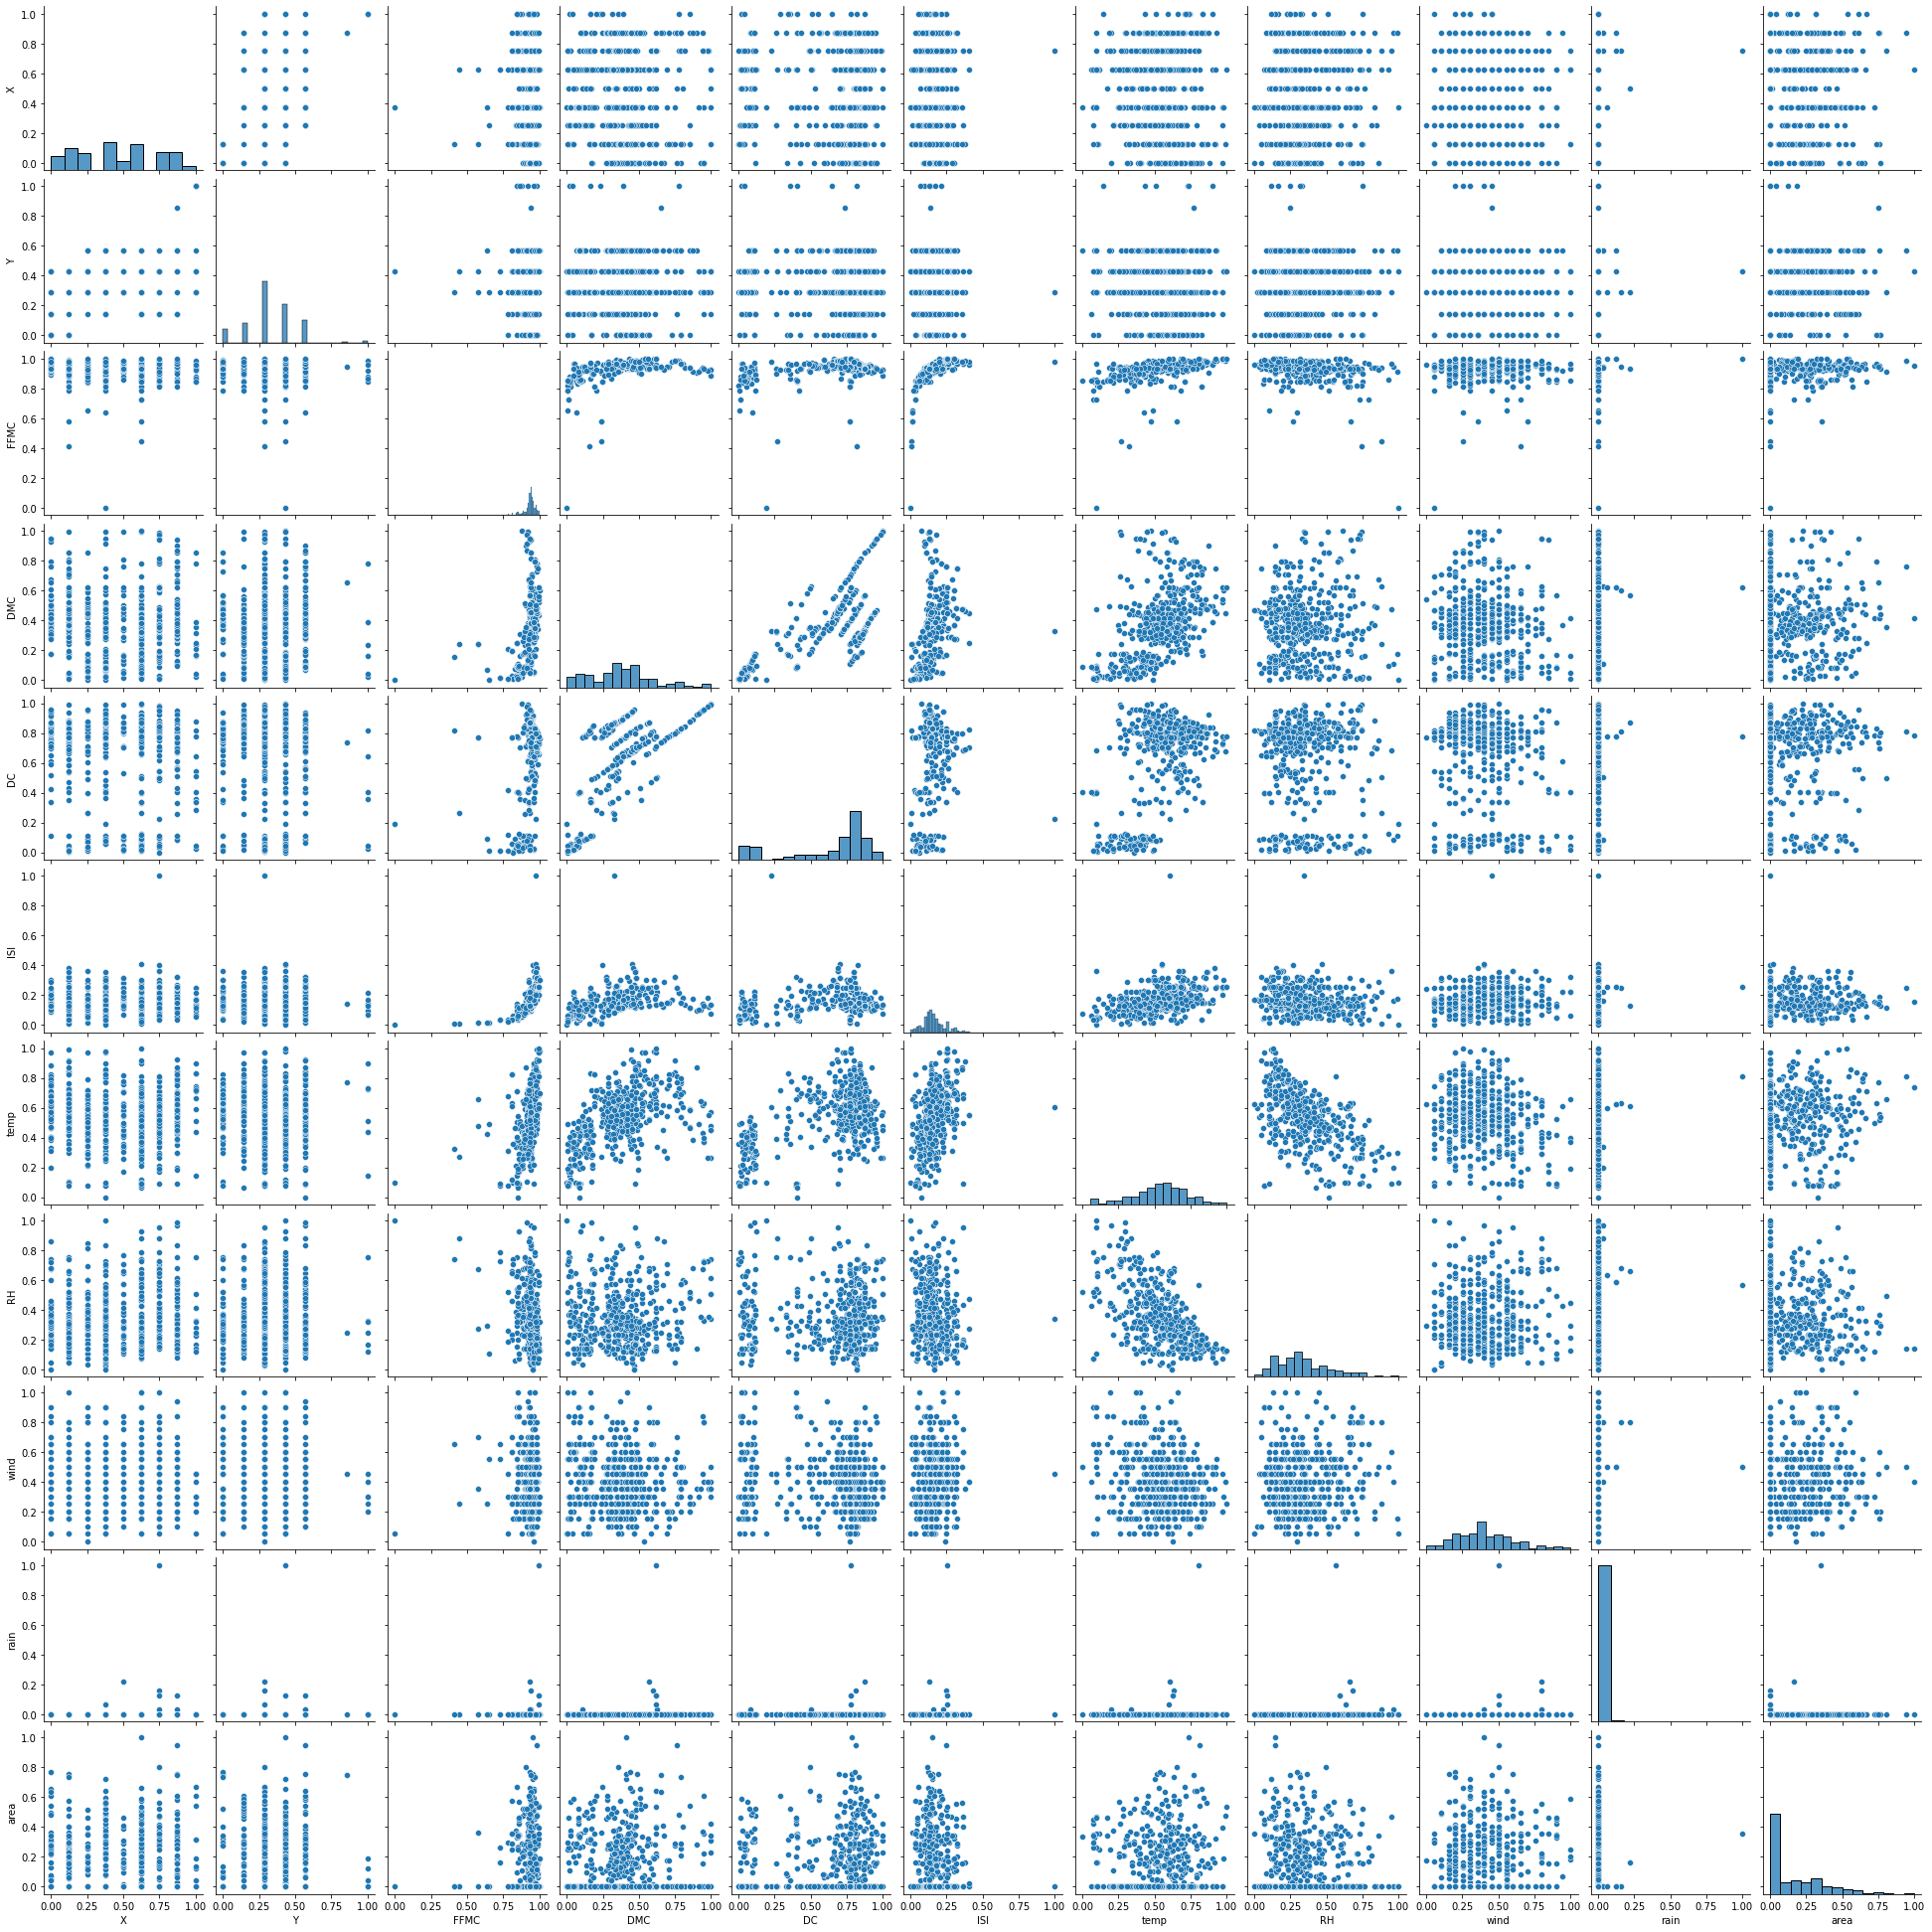

In [17]:
sns.pairplot(data = data2)
plt.show()

### Heat Map

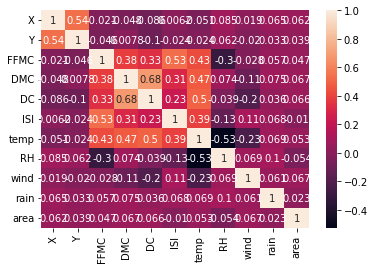

In [18]:
sns.heatmap(data=data2.corr(), annot=True)
plt.show()

### BoxPlot

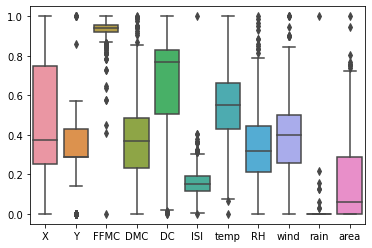

In [19]:
sns.boxplot(data = data2)
plt.show()

### Distribution Plot

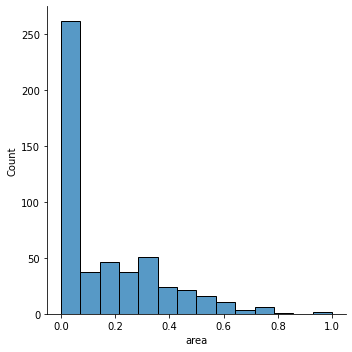

In [20]:
sns.displot(data2['area'])
plt.show()

## Split Data

### Independent and Dependent Data

In [21]:
X = data.drop(columns= 'area')
Y = data['area']

### Data Training and Testing

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)

In [23]:
X_train.shape

(413, 29)

In [24]:
X_test.shape

(104, 29)

In [25]:
y_train.shape

(413,)

In [26]:
y_test.shape

(104,)

## Eksperimen 1

### Parameter Tuning

In [142]:
def build_model(optimizer):
  model = Sequential()
  model.add(Dense(8, input_dim=29, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dropout(rate=0.1)) 

  model.add(Dense(8, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dropout(rate=0.1)) 

  model.add(Dense(8, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dropout(rate=0.1)) 

  model.add(Dense(1, activation='linear'))

  model.compile(loss='mean_squared_error', optimizer = 'adam', metrics=['accuracy'])

  return model 

In [143]:
regressor1 = KerasRegressor(build_fn = build_model)

In [144]:
parameters = {
    'batch_size': [8, 16, 25, 32, 64], 
    'epochs': [100, 500, 1000], 
    'optimizer': ['adam', 'rmsprop']
    }

In [145]:
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [146]:
gridsearch1 = GridSearchCV(
    estimator = regressor1,
    param_grid = parameters,
    scoring = 'neg_mean_squared_error',
    cv = 5
)

In [148]:
gridsearch1 = gridsearch1.fit(X_train, y_train, verbose = 1)

Output streaming akan dipotong hingga 5000 baris terakhir.
6/6 [==============================] - 0s 3ms/step - loss: 0.0283 - accuracy: 0.4758
Epoch 602/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0290 - accuracy: 0.4758
Epoch 603/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.0282 - accuracy: 0.4758
Epoch 604/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0275 - accuracy: 0.4758
Epoch 605/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0297 - accuracy: 0.4758
Epoch 606/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.0308 - accuracy: 0.4758
Epoch 607/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0290 - accuracy: 0.4758
Epoch 608/1000
6/6 [==============================] - 0s 6ms/step - loss: 0.0291 - accuracy: 0.4758
Epoch 609/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0280 - accuracy: 0.4758
Epoch 610/1000
6/6 [==============================] - 0s

In [149]:
gridsearch1.best_params_

{'batch_size': 64, 'epochs': 100, 'optimizer': 'rmsprop'}

In [150]:
gridsearch1.best_score_

-0.0389179517581013

### Build Model

In [151]:
model1 = Sequential(name = 'eksperimen1')
model1.add(Dense(8, input_dim=29, activation='relu', kernel_initializer='he_uniform'))
model1.add(Dropout(rate=0.1)) 

model1.add(Dense(8, activation='relu', kernel_initializer='he_uniform'))
model1.add(Dropout(rate=0.1)) 

model1.add(Dense(8, activation='relu', kernel_initializer='he_uniform'))
model1.add(Dropout(rate=0.1)) 

model1.add(Dense(1, activation='linear'))

model1.compile(loss='mean_squared_error', optimizer = 'rmsprop', metrics=['accuracy'])

In [152]:
model1.summary()

Model: "eksperimen1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_935 (Dense)            (None, 8)                 240       
_________________________________________________________________
dropout_576 (Dropout)        (None, 8)                 0         
_________________________________________________________________
dense_936 (Dense)            (None, 8)                 72        
_________________________________________________________________
dropout_577 (Dropout)        (None, 8)                 0         
_________________________________________________________________
dense_937 (Dense)            (None, 8)                 72        
_________________________________________________________________
dropout_578 (Dropout)        (None, 8)                 0         
_________________________________________________________________
dense_938 (Dense)            (None, 1)                 

In [153]:
model1.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

### Train Model

In [154]:
es1 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
mc1 = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [155]:
history1 = model1.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 64, epochs = 100, verbose = 1, callbacks=[es1, mc1])

Epoch 1/100
7/7 [==============================] - 1s 33ms/step - loss: 0.5082 - accuracy: 0.3099 - val_loss: 0.1738 - val_accuracy: 0.3462

Epoch 00001: val_accuracy improved from -inf to 0.34615, saving model to best_model.h5
Epoch 2/100
7/7 [==============================] - 0s 5ms/step - loss: 0.2977 - accuracy: 0.3414 - val_loss: 0.0979 - val_accuracy: 0.4519

Epoch 00002: val_accuracy improved from 0.34615 to 0.45192, saving model to best_model.h5
Epoch 3/100
7/7 [==============================] - 0s 5ms/step - loss: 0.1969 - accuracy: 0.3777 - val_loss: 0.0777 - val_accuracy: 0.4808

Epoch 00003: val_accuracy improved from 0.45192 to 0.48077, saving model to best_model.h5
Epoch 4/100
7/7 [==============================] - 0s 4ms/step - loss: 0.1353 - accuracy: 0.4334 - val_loss: 0.0765 - val_accuracy: 0.4808

Epoch 00004: val_accuracy did not improve from 0.48077
Epoch 5/100
7/7 [==============================] - 0s 5ms/step - loss: 0.1551 - accuracy: 0.4334 - val_loss: 0.0769 -

### Visualize Results

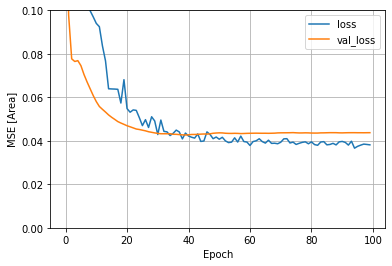

In [156]:
plt.plot(history1.history['loss'], label='loss')
plt.plot(history1.history['val_loss'], label='val_loss')

plt.ylim([0, 0.1])
plt.xlabel('Epoch')
plt.ylabel('MSE [Area]')
plt.legend()
plt.grid(True)

plt.show()

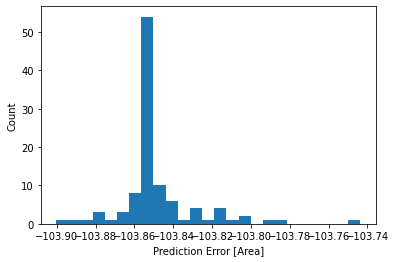

In [157]:
y_predictions1 = model1.predict(X_test).flatten()

error = y_predictions1 - y_test.to_numpy().flatten().shape
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [Area]')
_ = plt.ylabel('Count')

## Eksperimen 2

### Parameter Tuning

In [158]:
def build_model2(optimizer):
  model = Sequential()
  model.add(Dense(8, input_dim=1, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dropout(rate=0.1)) 

  model.add(Dense(8, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dropout(rate=0.1)) 

  model.add(Dense(8, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dropout(rate=0.1)) 

  model.add(Dense(1, activation='linear'))

  model.compile(loss='mean_squared_error', optimizer = 'adam', metrics=['accuracy'])

  return model

In [159]:
regressor2 = KerasRegressor(build_fn = build_model2)

In [160]:
gridsearch2 = GridSearchCV(
    estimator = regressor2,
    param_grid = parameters,
    scoring = 'neg_mean_squared_error',
    cv = 5
)

In [161]:
gridsearch2 = gridsearch2.fit(X_train['X'], y_train, verbose = 1)

Output streaming akan dipotong hingga 5000 baris terakhir.
6/6 [==============================] - 0s 3ms/step - loss: 0.0358 - accuracy: 0.4653
Epoch 502/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.0361 - accuracy: 0.4653
Epoch 503/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0364 - accuracy: 0.4653
Epoch 504/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0361 - accuracy: 0.4653
Epoch 505/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.0368 - accuracy: 0.4653
Epoch 506/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0370 - accuracy: 0.4653
Epoch 507/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.0370 - accuracy: 0.4653
Epoch 508/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.0362 - accuracy: 0.4653
Epoch 509/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.0363 - accuracy: 0.4653
Epoch 510/1000
6/6 [==============================] - 0s

In [162]:
gridsearch2.best_params_

{'batch_size': 16, 'epochs': 1000, 'optimizer': 'adam'}

In [163]:
gridsearch2.best_score_

-0.03837390566135861

### Build Model

In [166]:
model2 = Sequential(name = 'eksperimen2')
model2.add(Dense(8, input_dim=1, activation='relu', kernel_initializer='he_uniform'))
model2.add(Dropout(rate=0.1)) 

model2.add(Dense(8, activation='relu', kernel_initializer='he_uniform'))
model2.add(Dropout(rate=0.1)) 

model2.add(Dense(8, activation='relu', kernel_initializer='he_uniform'))
model2.add(Dropout(rate=0.1)) 

model2.add(Dense(1, activation='linear'))

model2.compile(loss='mean_squared_error', optimizer = 'adam', metrics=['accuracy']) 

In [167]:
model2.summary()

Model: "eksperimen2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1547 (Dense)           (None, 8)                 16        
_________________________________________________________________
dropout_1035 (Dropout)       (None, 8)                 0         
_________________________________________________________________
dense_1548 (Dense)           (None, 8)                 72        
_________________________________________________________________
dropout_1036 (Dropout)       (None, 8)                 0         
_________________________________________________________________
dense_1549 (Dense)           (None, 8)                 72        
_________________________________________________________________
dropout_1037 (Dropout)       (None, 8)                 0         
_________________________________________________________________
dense_1550 (Dense)           (None, 1)                 

### Train Model

In [168]:
es2 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
mc2 = ModelCheckpoint('best_model.h6', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [169]:
history2 = model2.fit(X_train['X'], y_train, validation_data = (X_test['X'], y_test), batch_size = 16, epochs = 1000, verbose = 1, callbacks=[es2, mc2])

Epoch 1/1000
26/26 [==============================] - 1s 7ms/step - loss: 0.2540 - accuracy: 0.4649 - val_loss: 0.1005 - val_accuracy: 0.4904

Epoch 00001: val_accuracy improved from -inf to 0.49038, saving model to best_model.h6
INFO:tensorflow:Assets written to: best_model.h6/assets
Epoch 2/1000
26/26 [==============================] - 0s 2ms/step - loss: 0.1498 - accuracy: 0.4625 - val_loss: 0.0600 - val_accuracy: 0.4904

Epoch 00002: val_accuracy did not improve from 0.49038
Epoch 3/1000
26/26 [==============================] - 0s 2ms/step - loss: 0.0949 - accuracy: 0.4576 - val_loss: 0.0477 - val_accuracy: 0.4904

Epoch 00003: val_accuracy did not improve from 0.49038
Epoch 4/1000
26/26 [==============================] - 0s 2ms/step - loss: 0.1194 - accuracy: 0.4552 - val_loss: 0.0457 - val_accuracy: 0.4904

Epoch 00004: val_accuracy did not improve from 0.49038
Epoch 5/1000
26/26 [==============================] - 0s 2ms/step - loss: 0.0759 - accuracy: 0.4673 - val_loss: 0.0453 -

### Visualize Results

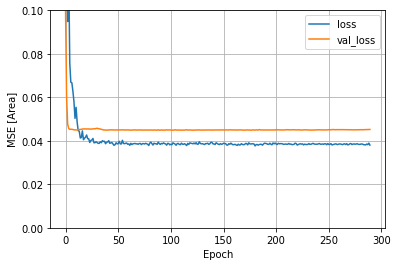

In [170]:
plt.plot(history2.history['loss'], label='loss')
plt.plot(history2.history['val_loss'], label='val_loss')

plt.ylim([0, 0.1])
plt.xlabel('Epoch')
plt.ylabel('MSE [Area]')
plt.legend()
plt.grid(True)

plt.show()

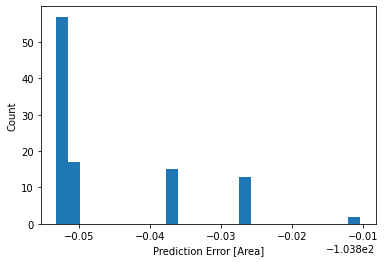

In [171]:
y_predictions2 = model2.predict(X_test['X']).flatten()

error = y_predictions2 - y_test.to_numpy().flatten().shape
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [Area]')
_ = plt.ylabel('Count')

(0.0, 1.0)

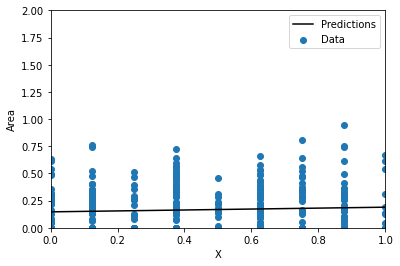

In [172]:
x = tf.linspace(0.0, 250, 251)
y_predictions2 = model2.predict(x)

plt.scatter(X_train['X'], y_train, label='Data')
plt.plot(x, y_predictions2, color='k', label='Predictions')
plt.xlabel('X')
plt.ylabel('Area')
plt.legend()

plt.ylim([0, 2])
plt.xlim([0, 1])

## Eksperimen 3

### Build Model

In [27]:
model3 = Sequential(name = 'eksperimen3')
model3.add(Dense(8, input_dim=1, activation='relu', kernel_initializer='he_uniform'))
model3.add(Dropout(rate=0.1)) 

model3.add(Dense(8, activation='relu', kernel_initializer='he_uniform'))
model3.add(Dropout(rate=0.1)) 

model3.add(Dense(8, activation='relu', kernel_initializer='he_uniform'))
model3.add(Dropout(rate=0.1)) 

model3.add(Dense(1, activation='linear'))

model3.compile(loss='mean_squared_error', optimizer = 'adam', metrics=['accuracy']) 

In [28]:
model3.summary()

Model: "eksperimen3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 16        
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 72        
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 

### Train Model

In [29]:
es3 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
mc3 = ModelCheckpoint('best_model.h7', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [30]:
history3 = model3.fit(X_train['DC'], y_train, validation_data = (X_test['DC'], y_test), batch_size = 16, epochs = 1000, verbose = 1, callbacks = [es3, mc3])

Epoch 1/1000
26/26 [==============================] - 1s 8ms/step - loss: 1.0922 - accuracy: 0.4552 - val_loss: 0.2537 - val_accuracy: 0.4904

Epoch 00001: val_accuracy improved from -inf to 0.49038, saving model to best_model.h7
INFO:tensorflow:Assets written to: best_model.h7/assets
Epoch 2/1000
26/26 [==============================] - 0s 2ms/step - loss: 0.4704 - accuracy: 0.4140 - val_loss: 0.0701 - val_accuracy: 0.4904

Epoch 00002: val_accuracy did not improve from 0.49038
Epoch 3/1000
26/26 [==============================] - 0s 2ms/step - loss: 0.3854 - accuracy: 0.3971 - val_loss: 0.0579 - val_accuracy: 0.4904

Epoch 00003: val_accuracy did not improve from 0.49038
Epoch 4/1000
26/26 [==============================] - 0s 2ms/step - loss: 0.2786 - accuracy: 0.4068 - val_loss: 0.0528 - val_accuracy: 0.4904

Epoch 00004: val_accuracy did not improve from 0.49038
Epoch 5/1000
26/26 [==============================] - 0s 2ms/step - loss: 0.2346 - accuracy: 0.4140 - val_loss: 0.0508 -

### Visualize Results

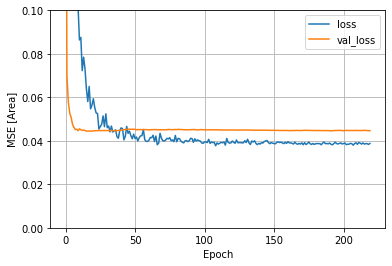

In [31]:
plt.plot(history3.history['loss'], label='loss')
plt.plot(history3.history['val_loss'], label='val_loss')

plt.ylim([0, 0.1])
plt.xlabel('Epoch')
plt.ylabel('MSE [Area]')
plt.legend()
plt.grid(True)

plt.show()

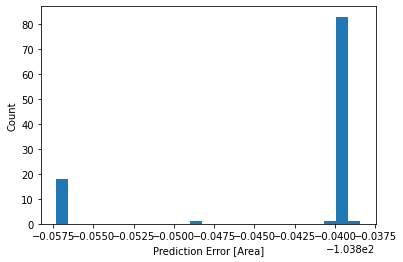

In [32]:
y_predictions3 = model3.predict(X_test['DC']).flatten()

error = y_predictions3 - y_test.to_numpy().flatten().shape
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [Area]')
_ = plt.ylabel('Count')

(0.0, 1.0)

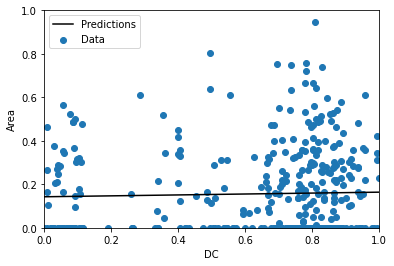

In [33]:
x = tf.linspace(0.0, 250, 251)
y_predictions3 = model3.predict(x)

plt.scatter(X_train['DC'], y_train, label='Data')
plt.plot(x, y_predictions3, color='k', label='Predictions')
plt.xlabel('DC')
plt.ylabel('Area')
plt.legend()

plt.ylim([0, 1])
plt.xlim([0, 1])